# Prevendo Preço de Ações com Deep Learning (LSTM)

# Baixando os dados do o Yahoo Finance com uso de biblioteca

```  
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install matplotlib
```

Importando o Yfinance + algumas coisinhas

In [48]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Vamos definir somente duas variaveis 

titulo = 'CAMB3.SA' # o papel a ser coletados os dados

periodo = '5y'  # o periodo ao qual os dados vao ser coletados.

In [49]:
#definindo variaveis
titulo = 'ITUB4.SA'


periodo = '5y' 
#Criando o data frame com os dados de saida.
stock = pd.DataFrame(yf.Ticker(titulo).history(period = periodo))

# O resultado de saida da biblioteca yfinance é um DF.

Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []

In [50]:
#mostrando DF
stock.head(4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-05-23 00:00:00-03:00,27.113034,27.380999,26.901913,27.226715,15793700,0.0,0.0
2019-05-24 00:00:00-03:00,27.445968,27.486567,26.804478,26.820719,11538100,0.0,0.0
2019-05-27 00:00:00-03:00,27.064326,27.267328,26.820720,26.918163,10607500,0.0,0.0
2019-05-28 00:00:00-03:00,27.023715,27.673326,26.893794,27.673326,32564800,0.0,0.0


# Importando bibliotecas de ML

``` 
!python.exe -m pip install --upgrade pip

pip install scikit-learn
pip install tensorflow[and-cuda]
pip install keras

```

Keras é derivado do TensorFLow e so funciona no python3.11 logo ha que instalar 


In [51]:
#Importando as libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM

Agora vamos criar o DataFrame, com um passo um pouco diferente que vou mostrar por que mais adiante:

In [52]:
#Cria-se um novo DF com indices de 0 - numero total de linhas do DF stock
# O DF recebe somente duas colunas do DF stock, as colunas Date (index) e Close
stock_close = pd.DataFrame(stock['Close'],columns=['Close'])

# Normalizando os dados entre 0 e 1.

In [53]:
scala = MinMaxScaler(feature_range=(0,1))
stock_close_scalado = scala.fit_transform(stock_close)


Separando em Variaveis de Teste e Variaveis de Treino.

Define quantos dias vamos tentar prever com o modelo setando a variavel `dias_a_prever`.

In [54]:
#aqui vamos separa as observacoes em duas partes vamos tentar prever os ultimos 60 dias

dias_a_prever = 30

stock_close_treino = stock_close[0:(len(stock.index)-dias_a_prever)]

stock_close_teste = stock_close[(len(stock.index)-dias_a_prever):]




# Criando um autorregressor.

Aqui se cria um train set que olha X dias para trás para realizar a previsão do que acontecerá em cada um dos dias.

Os dias podem ser alterados na variavel `dias_regressor`.

Em resumo ele calcula o dia com base nos valores dos n dias (igual a `dias_regressor`) dias anteriores.

Se o `dias_regressor` for 10, ele calcula o valor de hoje considerando os 10 ultimos valores.

In [55]:
dias_regressor = 45
units_do_modelo = 100

#aqui se criam duas listas vazias que vao receber os valores

x_train, y_train = [], []

for i in range(dias_regressor,len(stock_close_treino)):

    x_train.append(stock_close_scalado[i-dias_regressor:i,0])

    y_train.append(stock_close_scalado[i,0])
    
#x train é um array com o comjunto numero equivalente a regressor de observacoes por linha
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


# Criando o Modelo


In [56]:
model = Sequential()

model.add(LSTM(units=units_do_modelo, return_sequences=True, input_shape=(dias_regressor,1)))

model.add(LSTM(units=1))

#As units são as unidades de memória, como "repositórios de memória" (células) você colocará para passar os filtros.

/home/bruno/Documentos/Python/prevendo_precos_acoes_LSTM/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Aqui colocamos a loss function, que é a função de minimização. Isso quer dizer que eu quero minimizar o Erro Quadrático Médio (EQM), ou seja, o quanto a minha previsão desvia-se do real.

O otimizador é chamado Adam, ou estimador de momentos adaptativo.

In [57]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x=x_train, y=y_train, epochs=4, batch_size=1, verbose=2)

Epoch 1/4
1169/1169 - 9s - 7ms/step - loss: 0.0072
Epoch 2/4
1169/1169 - 8s - 7ms/step - loss: 0.0035
Epoch 3/4
1169/1169 - 8s - 7ms/step - loss: 0.0024
Epoch 4/4
1169/1169 - 7s - 6ms/step - loss: 0.0021


In [58]:
#Prevendo os 143 últimos preços de ação, baseado nos 90 últimos.

#inputs recebe os valores de stock close com o numero de dias antes da 
#quantidade definida para testes... OU seja dias de teste + regressor
inputs = stock_close[len(stock_close) - len(stock_close_teste) - dias_regressor:]
inputs  = scala.transform(inputs)
# inputs = inputs.reshape(-1,1)

x_test = []
for i in range(dias_regressor,inputs.shape[0]): # de 90 a 150
    x_test.append(inputs[i-dias_regressor:i,0])
x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

closing_price = model.predict(x=x_test)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


E agora revertendo o scaling que fizemos no início para voltar aos preços reais da ação.


In [59]:
closing_price = scala.inverse_transform(closing_price)

2024-04-15 00:00:00-03:00
2024-04-16 00:00:00-03:00


/tmp/ipykernel_30574/4033170138.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_close_teste['Predictions'] = closing_price


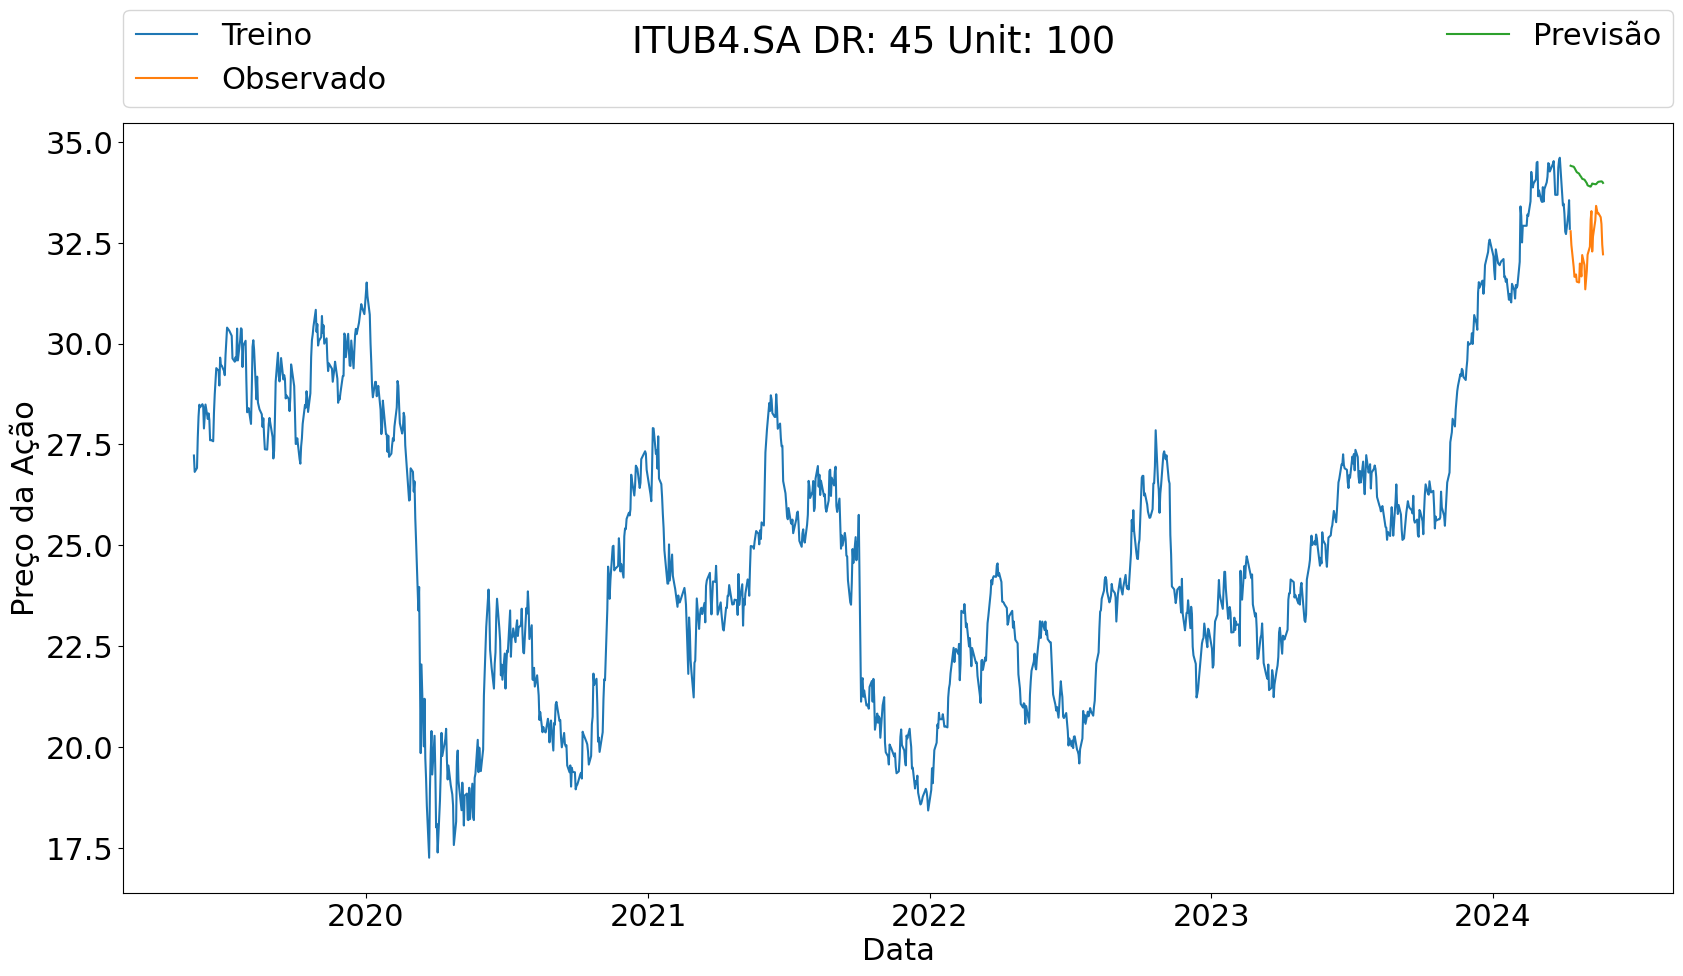

In [60]:
#Visualizando a Previsão
# train = stock_close_treino

plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))

# t_2020 = train['2020']

stock_close_teste['Predictions'] = closing_price

plt.ylabel('Preço da Ação')
plt.xlabel('Data')
plt.suptitle(titulo + ' DR: ' + str(dias_regressor) + ' Unit: ' + str(units_do_modelo))
plt.plot(stock_close_treino['Close'], label = "Treino")
plt.plot(stock_close_teste['Close'], label = 'Observado')
plt.plot(stock_close_teste['Predictions'], label = 'Previsão')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)

dia = stock_close_teste.index[2]
print(dia)
print(dia + pd.Timedelta(1, unit='d'))


# Descobrindo o valor do dia seguinte (D+1)

In [61]:
def estimar_valor_seguinte(stock_close:pd.DataFrame,dias_regressor:int):

    #definindo a data
    data_dia_seguinte = stock_close.index[len(stock_close.index)-1] + pd.Timedelta(1, unit='d')
    print(f'Realizaremos a previsao do dia: {data_dia_seguinte}...')

    # Pegar dos dados inciais os ultimios valores de acordo com a variavel de n regressores.
    print(f'Coletando as ultimas observacoes dos {dias_regressor} ultimos dias...')
    previsao_dia_seg = stock_close[len(stock_close)-dias_regressor:len(stock_close)]
    #escalar os dados... de retorno a funcao retornar um array
    previsao_dia_seg = scala.transform(
        previsao_dia_seg)
    #transforma o array em uma linha com varios valores.
    previsao_dia_seg = previsao_dia_seg.reshape(1,-1)
    #transorma os dados no formato que deve ser inserido no model
    previsao_dia_seg = np.reshape(
        previsao_dia_seg,
        (previsao_dia_seg.shape[0],
         previsao_dia_seg.shape[1],1))
    # prevendo o valor
    valor_previsto = model.predict(previsao_dia_seg)
    #retornando a escalo normal
    valor_previsto = scala.inverse_transform(valor_previsto)
    print(f'O vlaor previsto para o dia {data_dia_seguinte} é : {valor_previsto[0][0]}')

    #criando um DF com os dados gerados
    df_previsto = pd.DataFrame(
        [[None, valor_previsto[0][0]]],
        columns=['Close','Predictions'],
        index=[data_dia_seguinte])
    return df_previsto
    

Prevendo os proximos n dias...

In [62]:
n_dias = 15
for _ in range(n_dias):
    df_previsto = estimar_valor_seguinte(
        stock_close,
        dias_regressor)
    #concatenando os dados ao df de previsoes
    stock_close_teste = pd.concat(
        [stock_close_teste,df_previsto] )

    ######## ATUALIZANDO A TABELA DE STOCK ORIGINAL ########
    df_previsto['Close'] = df_previsto['Predictions']
    stock_close = pd.concat(
        [stock_close,df_previsto['Close']] )

stock_close.drop(
    stock_close.index[n_dias*-1:],axis=0, inplace=True)


Realizaremos a previsao do dia: 2024-05-24 00:00:00-03:00...
Coletando as ultimas observacoes dos 45 ultimos dias...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
O vlaor previsto para o dia 2024-05-24 00:00:00-03:00 é : 33.93264389038086
Realizaremos a previsao do dia: 2024-05-25 00:00:00-03:00...
Coletando as ultimas observacoes dos 45 ultimos dias...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
O vlaor previsto para o dia 2024-05-25 00:00:00-03:00 é : 33.96611785888672
Realizaremos a previsao do dia: 2024-05-26 00:00:00-03:00...
Coletando as ultimas observacoes dos 45 ultimos dias...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
O vlaor previsto para o dia 2024-05-26 00:00:00-03:00 é : 34.026283264160156
Realizaremos a previsao do dia: 2024-05-27 00:00:00-03:00...
Coletando as ultimas observacoes dos 45 ultimos dias...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
O vlaor previsto para o dia 2024-05-27 00:00:00-03:00 é : 34.087486267089844
Realizaremos a previsao do dia: 2024-05-28 00:00:00-03:00...
Coletando as

/tmp/ipykernel_30574/2317364579.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_close_teste = pd.concat(
/tmp/ipykernel_30574/2317364579.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_close_teste = pd.concat(
/tmp/ipykernel_30574/2317364579.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
O vlaor previsto para o dia 2024-05-31 00:00:00-03:00 é : 34.22650909423828
Realizaremos a previsao do dia: 2024-06-01 00:00:00-03:00...
Coletando as ultimas observacoes dos 45 ultimos dias...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
O vlaor previsto para o dia 2024-06-01 00:00:00-03:00 é : 34.24870300292969
Realizaremos a previsao do dia: 2024-06-02 00:00:00-03:00...
Coletando as ultimas observacoes dos 45 ultimos dias...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
O vlaor previsto para o dia 2024-06-02 00:00:00-03:00 é : 34.27009963989258
Realizaremos a previsao do dia: 2024-06-03 00:00:00-03:00...
Coletando as ultimas observacoes dos 45 ultimos dias...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
O vlaor previsto para o dia 2024-06-03 00:00:00-03:00 é : 34.29118728637695
Realizaremos a previsao do dia: 2024-06-04 00:00:00-03:00...
Coletando as ultimas observacoes dos 45 ultimos dias...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
O vlaor previsto para o dia 2024-06-04

/tmp/ipykernel_30574/2317364579.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_close_teste = pd.concat(
/tmp/ipykernel_30574/2317364579.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_close_teste = pd.concat(
/tmp/ipykernel_30574/2317364579.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
O vlaor previsto para o dia 2024-06-07 00:00:00-03:00 é : 34.36370849609375


/tmp/ipykernel_30574/2317364579.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_close_teste = pd.concat(


# Plotando a previsao...

Previsao de variacao de: -0.1365493517369032 %


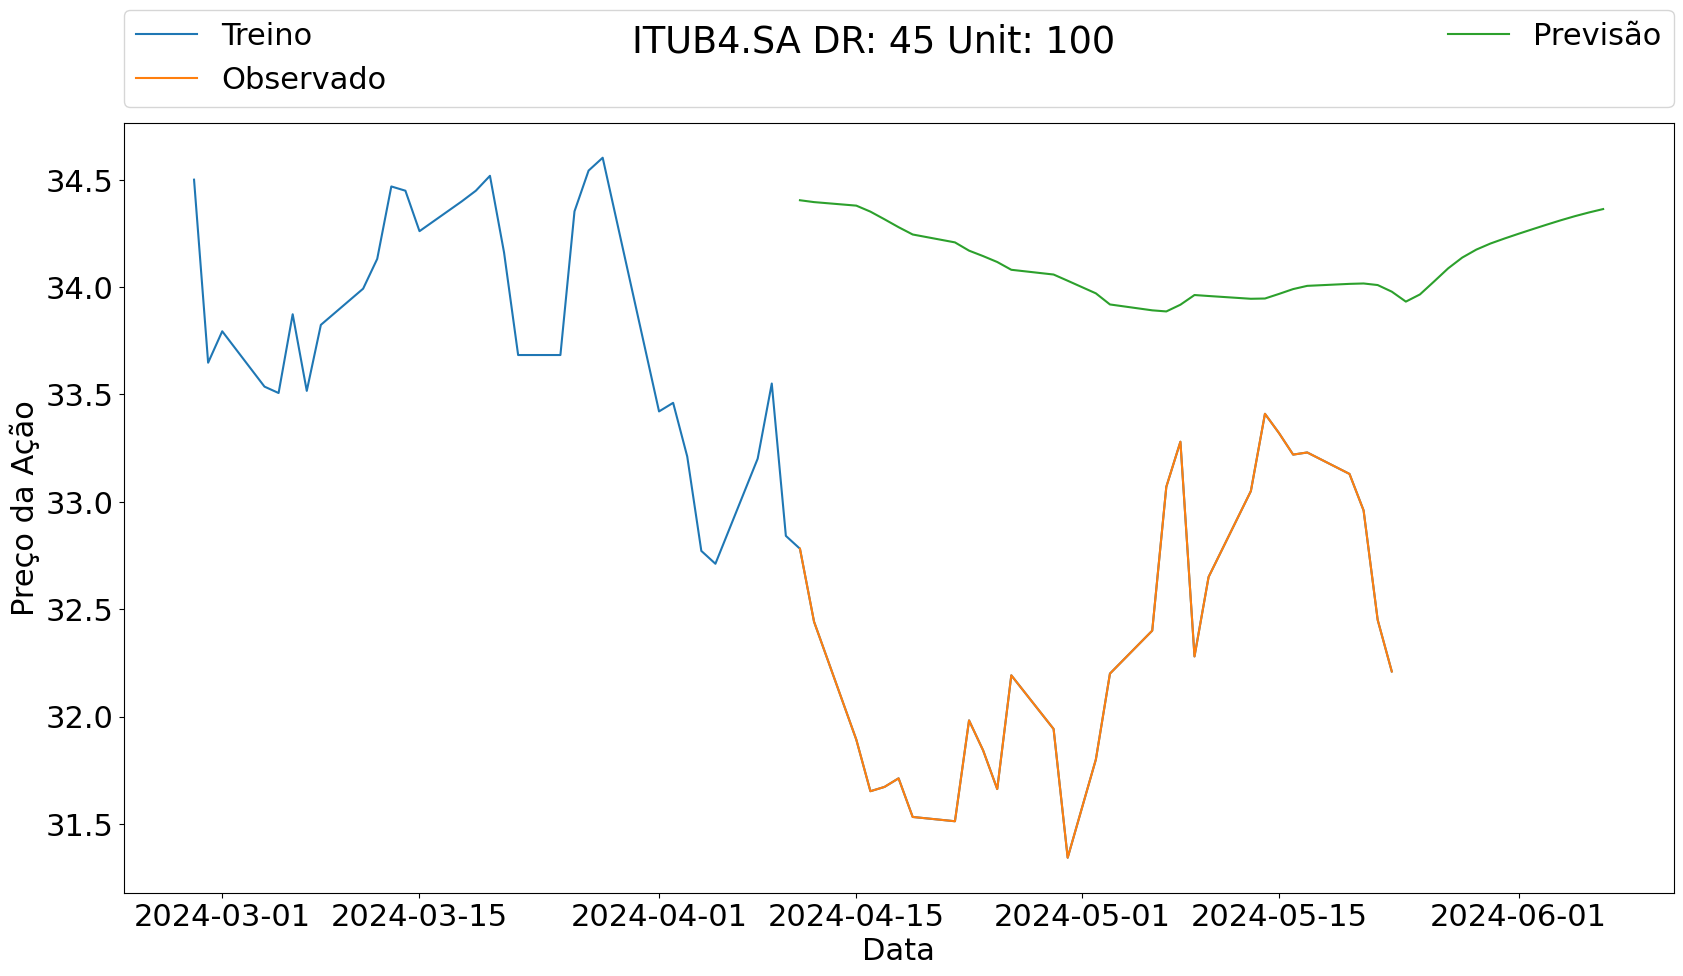

In [63]:
#Visualizando a Previsão
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))

plt.ylabel('Preço da Ação')
plt.xlabel('Data')
plt.suptitle(titulo + ' DR: ' + str(dias_regressor) + ' Unit: ' + str(units_do_modelo))
# plt.plot(stock_close_treino['Close'], label = "Treino")
plt.plot(stock_close.tail(dias_a_prever*2)['Close'], label = "Treino")
plt.plot(stock_close_teste['Close'], label = 'Observado')
plt.plot(stock_close_teste['Predictions'], label = 'Previsão')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)


#valor previsto de hoje - valor de ontem / valor de ontem
print(f'Previsao de variacao de: { ((stock_close_teste["Predictions"].values[n_dias*-1] - stock_close_teste["Predictions"].values[n_dias*-1 - 1] ) / stock_close_teste["Predictions"].values[n_dias*-1 - 1] )*100 } %')




In [64]:
print(stock_close_teste.tail())

                           Close  Predictions
2024-06-03 00:00:00-03:00    NaN    34.291187
2024-06-04 00:00:00-03:00    NaN    34.311611
2024-06-05 00:00:00-03:00    NaN    34.330688
2024-06-06 00:00:00-03:00    NaN    34.347996
2024-06-07 00:00:00-03:00    NaN    34.363708


In [65]:
df_previsto

,Close,Predictions
2024-06-07 00:00:00-03:00,34.363708,34.363708
